In [1]:
# Step 1 — Load (Excel) & Clean UCI Online Retail (script-style)
# What this script does:
# 1) Load the UCI Online Retail EXCEL file (path below).
# 2) Remove any row with at least one missing value (NaN / "" / blank).
# 3) Drop exact duplicate rows.
# 4) Remove returned/cancelled invoices (InvoiceNo starting with 'C').
# 5) Remove negative values in Quantity and UnitPrice.
# 6) Print the shape (rows, cols) before and after cleaning.

from pathlib import Path
import numpy as np
import pandas as pd


In [2]:
#path
DATA_PATH = Path("/mnt/f/online+retail/Online Retail.xlsx")

if not DATA_PATH.exists():
    raise FileNotFoundError(f"Excel file not found: {DATA_PATH.resolve()}")

In [3]:
#Load raw data
df = pd.read_excel(DATA_PATH, dtype={"InvoiceNo": str, "StockCode": str})
df["InvoiceNo"] = df["InvoiceNo"].astype("string")
df["StockCode"]  = df["StockCode"].astype("string")

expected_cols = ["InvoiceNo", "StockCode", "Description", "Quantity",
                 "InvoiceDate", "UnitPrice", "CustomerID", "Country"]
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    print(f"Warning: missing expected columns: {missing}")

shape_before = df.shape

In [4]:
#Normalize empty strings
for col in df.columns:
    if pd.api.types.is_string_dtype(df[col]):
        s = df[col].astype("string").str.strip()
        df[col] = s.mask(s == "", np.nan)

In [5]:
#Coerce numerics if needed
for col in ["Quantity", "UnitPrice", "CustomerID"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

In [6]:
df = df.dropna(axis=0, how="any")

In [7]:
df = df.drop_duplicates()

In [8]:
if "InvoiceNo" in df.columns:
    df = df[~df["InvoiceNo"].str.startswith("C")]


In [9]:
if "Quantity" in df.columns:
    df = df[df["Quantity"] >= 0]
if "UnitPrice" in df.columns:
    df = df[df["UnitPrice"] >= 0]

In [10]:
# Convert Quantity to integer if all values are integral
if "Quantity" in df.columns and pd.api.types.is_float_dtype(df["Quantity"]):
    # Check fractional parts are all zero
    if np.all(np.modf(df["Quantity"].to_numpy())[0] == 0):
        df["Quantity"] = df["Quantity"].astype("int64")

# Parse InvoiceDate to datetime (useful later); drop rows where parsing fails
if "InvoiceDate" in df.columns and not pd.api.types.is_datetime64_any_dtype(df["InvoiceDate"]):
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
    df = df.dropna(subset=["InvoiceDate"])

In [11]:
shape_after = df.shape
print(f"Loaded shape:           {shape_before}")
print(f"Shape after  cleaning:  {shape_after}")

Loaded shape:           (541909, 8)
Shape after  cleaning:  (392732, 8)


In [12]:
# Step 2 — Build Transaction × Item binary matrix (script-style, no functions)
# Represent data as a binary matrix where rows are invoices (transactions)
# and columns are items (StockCode). Entry (i, j) = 1 if item j appears in
# invoice i, otherwise 0. We use a sparse CSR matrix for scalability.
from scipy import sparse

In [13]:
tx_item = (
    df.loc[:, ["InvoiceNo", "StockCode"]]
      .drop_duplicates(ignore_index=True)
)

tx_item = tx_item.sort_values(["InvoiceNo", "StockCode"], kind="mergesort", ignore_index=True)

In [14]:
tx_item["txn_id"]  = tx_item["InvoiceNo"].astype("category").cat.codes
tx_item["item_id"] = tx_item["StockCode"].astype("category").cat.codes

n_txn  = tx_item["txn_id"].max() + 1
n_item = tx_item["item_id"].max() + 1

In [15]:
#Build sparse matrix
row_idx = tx_item["txn_id"].to_numpy(dtype=np.int64, copy=False)
col_idx = tx_item["item_id"].to_numpy(dtype=np.int64, copy=False)
data    = np.ones(row_idx.shape[0], dtype=np.uint8)

X = sparse.csr_matrix((data, (row_idx, col_idx)), shape=(n_txn, n_item))

In [16]:
txn_index_to_invoiceno = (
    tx_item[["InvoiceNo", "txn_id"]]
    .drop_duplicates(subset=["txn_id"])
    .sort_values("txn_id", kind="mergesort")
    .reset_index(drop=True)["InvoiceNo"]
)

item_index_to_stockcode = (
    tx_item[["StockCode", "item_id"]]
    .drop_duplicates(subset=["item_id"])
    .sort_values("item_id", kind="mergesort")
    .reset_index(drop=True)["StockCode"]
)

In [17]:
num_nonzeros = X.nnz
sparsity = 1.0 - (num_nonzeros / (X.shape[0] * X.shape[1])) if X.shape[0] * X.shape[1] > 0 else 1.0

print("Transaction-Item matrix (binary) — CSR")
print(f"  shape:         {X.shape}  (transactions × items)")
print(f"  non-zeros:     {num_nonzeros}")
print(f"  density:       {num_nonzeros / (X.shape[0]*X.shape[1]):.8f}")
print(f"  sparsity:      {sparsity:.8f}")

Transaction-Item matrix (binary) — CSR
  shape:         (18536, 3665)  (transactions × items)
  non-zeros:     387875
  density:       0.00570955
  sparsity:      0.99429045


In [18]:
# Step 3— Streaming simulation by chronological batches 
# Split transactions into sequential time-ordered batches to simulate
# streaming data arrival and enable time-evolving matrix monitoring.

In [19]:
invoice_time = (
    df.loc[:, ["InvoiceNo", "InvoiceDate"]]
      .drop_duplicates(subset=["InvoiceNo"], keep="first")
)


txn_map = (
    tx_item.loc[:, ["InvoiceNo", "txn_id"]]
           .drop_duplicates(subset=["InvoiceNo"], keep="first")
)

txn_timeline = (
    txn_map.merge(invoice_time, on="InvoiceNo", how="inner")
           .sort_values("InvoiceDate", kind="mergesort", ignore_index=True)
)


ordered_txn_ids = txn_timeline["txn_id"].to_numpy(dtype=np.int64, copy=False)
ordered_dates   = txn_timeline["InvoiceDate"].to_numpy(copy=False)
n_txn = ordered_txn_ids.shape[0]

In [20]:
#Choose a sensible batch plan
target_avg_batch = int(np.clip(n_txn // 20, 1000, 10_000)) if n_txn > 0 else 0
n_batches = int(np.ceil(n_txn / target_avg_batch)) if target_avg_batch > 0 else 0
n_batches = int(np.clip(n_batches, 8, 50)) if n_batches > 0 else 0
batch_size = int(np.ceil(n_txn / n_batches)) if n_batches > 0 else 0

print("Streaming simulation plan")
print(f"  total transactions:  {n_txn}")
print(f"  target avg batch:    {target_avg_batch}")
print(f"  chosen #batches:     {n_batches}")
print(f"  nominal batch size:  {batch_size}")

Streaming simulation plan
  total transactions:  18536
  target avg batch:    1000
  chosen #batches:     19
  nominal batch size:  976


In [21]:
#Slice transactions into batches
stream_batches_txn_ids = []
stream_batches_dates = []  # (start, end) timestamps for reporting

start = 0
for b in range(n_batches):
    end = min(start + batch_size, n_txn)
    if start >= end:
        break
    batch_txn_ids = ordered_txn_ids[start:end]
    stream_batches_txn_ids.append(batch_txn_ids)

    batch_dates = ordered_dates[start:end]
    stream_batches_dates.append((pd.to_datetime(batch_dates[0]),
                                 pd.to_datetime(batch_dates[-1])))
    start = end

In [22]:
print("\nBatches (chronological):")
for i, (ids, (d0, d1)) in enumerate(zip(stream_batches_txn_ids, stream_batches_dates), start=1):
    print(f"  Batch {i:02d}: "
          f"size={ids.size:6d} | "
          f"window=[{d0.strftime('%Y-%m-%d %H:%M')} → {d1.strftime('%Y-%m-%d %H:%M')}]")


Batches (chronological):
  Batch 01: size=   976 | window=[2010-12-01 08:26 → 2010-12-14 11:42]
  Batch 02: size=   976 | window=[2010-12-14 11:43 → 2011-01-19 12:34]
  Batch 03: size=   976 | window=[2011-01-19 12:38 → 2011-02-16 12:59]
  Batch 04: size=   976 | window=[2011-02-16 13:00 → 2011-03-14 13:25]
  Batch 05: size=   976 | window=[2011-03-14 13:35 → 2011-04-05 13:52]
  Batch 06: size=   976 | window=[2011-04-05 13:56 → 2011-05-01 10:51]
  Batch 07: size=   976 | window=[2011-05-01 11:10 → 2011-05-19 10:38]
  Batch 08: size=   976 | window=[2011-05-19 10:43 → 2011-06-09 08:45]
  Batch 09: size=   976 | window=[2011-06-09 09:16 → 2011-06-30 16:22]
  Batch 10: size=   976 | window=[2011-06-30 16:28 → 2011-07-24 10:54]
  Batch 11: size=   976 | window=[2011-07-24 11:06 → 2011-08-15 14:50]
  Batch 12: size=   976 | window=[2011-08-15 14:51 → 2011-09-06 13:11]
  Batch 13: size=   976 | window=[2011-09-06 13:20 → 2011-09-23 14:17]
  Batch 14: size=   976 | window=[2011-09-23 14:21 

In [23]:
# Step 4 — Part 1: From-scratch Gaussian Random Projection on streaming batches
# For each chronological batch (from step 3), compute a GRP sketch:
#   Y_batch = X_batch · R
# where R ~ N(0, 1/√k) is fixed across all batches to ensure comparability over time.
#
# Notes:
# - We do NOT compute analytics/metrics here; only the sketches per batch.
# - Implementation is from scratch (no sklearn). Uses NumPy + SciPy only.
# - X is CSR (transactions × items). R is dense (items × k). Y is dense (batch_size × k).
# - Keep R fixed across batches (same random seed) to make temporal comparisons meaningful.

from pathlib import Path
from scipy import sparse
import joblib


In [24]:
# ---------------------------- Preconditions ----------------------------
# Assumes the following are already defined from previous steps:
#   - X : csr_matrix, shape (n_txn_total, n_items)
#   - stream_batches_txn_ids : List[np.ndarray] of txn_id arrays (batches)
#   - stream_batches_dates  : List[Tuple[pd.Timestamp, pd.Timestamp]] (optional metadata)
#   - item_index_to_stockcode : pd.Series mapping col index -> StockCode
# These come from Steps 2 and 3.

n_txn_total, n_items = X.shape

In [25]:
if n_txn_total <= 1:
    raise ValueError("Not enough transactions to perform GRP.")

epsilon = 0.35
k_jl = int(np.ceil(4.0 * np.log(max(2, n_txn_total)) / (epsilon ** 2)))
k = int(np.clip(k_jl, 32, 256))

print("Gaussian Random Projection plan")
print(f"  items (d):             {n_items}")
print(f"  transactions (n):      {n_txn_total}")
print(f"  chosen target dim (k): {k}  (ε={epsilon})")

Gaussian Random Projection plan
  items (d):             3665
  transactions (n):      18536
  chosen target dim (k): 256  (ε=0.35)


In [26]:
#Build random matrix
rng = np.random.default_rng(seed=12345)
R = rng.standard_normal(size=(n_items, k), dtype=np.float32) / np.sqrt(k)
R = np.asarray(R, dtype=np.float32, order="C")  

In [27]:
out_dir = Path("artifacts/sketch_grp")
out_dir.mkdir(parents=True, exist_ok=True)

In [28]:
grp_index_manifest = []

for i, txn_ids in enumerate(stream_batches_txn_ids, start=1):
    X_batch = X[txn_ids, :]  # shape: (batch_size, n_items)
    if not sparse.isspmatrix_csr(X_batch):
        X_batch = sparse.csr_matrix(X_batch)


    Y_batch = (X_batch @ R).astype(np.float32, copy=False)


    batch_path = out_dir / f"grp_batch_{i:02d}.joblib"
    joblib.dump(
        {
            "Y_batch": Y_batch,                # float32, shape (batch_size, k)
            "txn_ids": txn_ids,               
            "k": k,
            "epsilon": epsilon,
            "R_seed": 12345,                   
            "shape_X_batch": X_batch.shape,
            "shape_R": R.shape,
        },
        batch_path
    )

    grp_index_manifest.append(
        {
            "batch_id": i,
            "file": str(batch_path),
            "batch_size": int(Y_batch.shape[0]),
            "txn_id_min": int(txn_ids.min()) if txn_ids.size else None,
            "txn_id_max": int(txn_ids.max()) if txn_ids.size else None,
        }
    )

    print(f"[GRP] Batch {i:02d}: X_batch{X_batch.shape} · R{R.shape} -> Y{Y_batch.shape}  => saved: {batch_path.name}")

[GRP] Batch 01: X_batch(976, 3665) · R(3665, 256) -> Y(976, 256)  => saved: grp_batch_01.joblib
[GRP] Batch 02: X_batch(976, 3665) · R(3665, 256) -> Y(976, 256)  => saved: grp_batch_02.joblib
[GRP] Batch 03: X_batch(976, 3665) · R(3665, 256) -> Y(976, 256)  => saved: grp_batch_03.joblib
[GRP] Batch 04: X_batch(976, 3665) · R(3665, 256) -> Y(976, 256)  => saved: grp_batch_04.joblib
[GRP] Batch 05: X_batch(976, 3665) · R(3665, 256) -> Y(976, 256)  => saved: grp_batch_05.joblib
[GRP] Batch 06: X_batch(976, 3665) · R(3665, 256) -> Y(976, 256)  => saved: grp_batch_06.joblib
[GRP] Batch 07: X_batch(976, 3665) · R(3665, 256) -> Y(976, 256)  => saved: grp_batch_07.joblib
[GRP] Batch 08: X_batch(976, 3665) · R(3665, 256) -> Y(976, 256)  => saved: grp_batch_08.joblib
[GRP] Batch 09: X_batch(976, 3665) · R(3665, 256) -> Y(976, 256)  => saved: grp_batch_09.joblib
[GRP] Batch 10: X_batch(976, 3665) · R(3665, 256) -> Y(976, 256)  => saved: grp_batch_10.joblib
[GRP] Batch 11: X_batch(976, 3665) · R(3

In [29]:
joblib.dump({"R": R, "k": k, "epsilon": epsilon, "seed": 12345, "n_items": n_items},
            out_dir / "grp_projection_matrix.joblib")
joblib.dump({"batches": grp_index_manifest}, out_dir / "grp_manifest.joblib")

print("GRP sketches complete. Projection matrix and manifest saved in 'artifacts/sketch_grp/'.")

GRP sketches complete. Projection matrix and manifest saved in 'artifacts/sketch_grp/'.


In [30]:
# Step 4 — Part 2: From-scratch Incremental PCA on streaming batches (per-batch IPCA)
# For each chronological batch (from Step 3), compute top-k PCA components

In [31]:
n_txn_total, d = X.shape

In [32]:
#Choose IPCA rank
k_ipca = int(np.clip(50, 2, min(128, d)))  


n_iter = 7     
tol    = 1e-6     
rng     = np.random.default_rng(123)  

out_dir = Path("artifacts/sketch_ipca")
out_dir.mkdir(parents=True, exist_ok=True)

def gram_schmidt_orth(x: np.ndarray, V: list[np.ndarray]) -> np.ndarray:
    """Orthonormalize vector x against an existing list of orthonormal vectors V."""
    if not V:
        return x
    for v in V:
        x -= (v @ x) * v
    # Normalize
    nrm = np.linalg.norm(x)
    if nrm > 0:
        x /= nrm
    return x

for b_idx, txn_ids in enumerate(stream_batches_txn_ids, start=1):
    Xb = X[txn_ids, :]             
    if not sparse.isspmatrix_csr(Xb):
        Xb = sparse.csr_matrix(Xb)
    n_b = Xb.shape[0]
    if n_b == 0:
        continue

    # μ_b = (1/n_b) * 1^T Xb  (vector of length d)
    mu_b = np.asarray(Xb.sum(axis=0)).ravel() / float(n_b)  # shape (d,)

    #Define covariance-vector product: C_b @ w
    # C_b @ w = (1/n_b) * Xb^T ( Xb w - (μ_b^T w) * 1 )
    ones_b = np.ones(n_b, dtype=np.float64)  

    def cov_times(w: np.ndarray) -> np.ndarray:
        # Ensure shape (d,)
        w = w.astype(np.float64, copy=False)
        Xw = Xb.dot(w)                                       # shape (n_b,)
        mu_dot_w = float(mu_b @ w)
        z = Xw - mu_dot_w * ones_b                           # Xc @ w
        Ct_w = (Xb.T.dot(z)) / float(n_b)                    # (1/n_b) * Xc^T (Xc w)
        return np.asarray(Ct_w).ravel()

   
    V = []                                 # list of eigenvectors (d,)
    S = []                                 # list of eigenvalues (variances)
    for comp in range(k_ipca):
        # Random init orthogonal to previous components
        w = rng.normal(size=d)
        w = gram_schmidt_orth(w, V)
        if np.linalg.norm(w) == 0:
            break

        last_val = 0.0
        for it in range(n_iter):
            u = cov_times(w)
            u = gram_schmidt_orth(u, V)

            # Normalize
            nrm = np.linalg.norm(u)
            if nrm == 0:
                break
            w = u / nrm

            lam = float(w @ cov_times(w))
            if abs(lam - last_val) <= tol * max(1.0, abs(lam)):
                break
            last_val = lam

        # Store component if meaningful
        eigval = float(w @ cov_times(w))
        if eigval <= 0 or not np.isfinite(eigval):
            break
        V.append(w.astype(np.float32, copy=False))
        S.append(eigval)

    # Stack results
    if V:
        components = np.stack(V, axis=1)           # shape (d, r), r <= k_ipca
        explained_variances = np.array(S, dtype=np.float32)  # λ_i
        # Singular values relate via σ_i = sqrt(λ_i * (n_b - 1)) if needed later.
    else:
        components = np.zeros((d, 0), dtype=np.float32)
        explained_variances = np.zeros((0,), dtype=np.float32)


    batch_path = out_dir / f"ipca_batch_{b_idx:02d}.joblib"
    joblib.dump(
        {
            "batch_id": b_idx,
            "txn_ids": txn_ids,
            "mean_batch": mu_b.astype(np.float32, copy=False),   # μ_b
            "components": components,                            # d × r
            "explained_variances": explained_variances,          # length r
            "n_samples_batch": int(n_b),
            "n_features": int(d),
            "k_target": int(k_ipca),
            "n_iter": int(n_iter),
            "tol": float(tol),
            "rng_seed": 123,
        },
        batch_path
    )

    print(f"[IPCA] Batch {b_idx:02d}: n={n_b}, d={d}, r={components.shape[1]}  -> saved: {batch_path.name}")

print("Incremental PCA (per-batch) sketches complete. Files in 'artifacts/sketch_ipca/'.")

[IPCA] Batch 01: n=976, d=3665, r=50  -> saved: ipca_batch_01.joblib
[IPCA] Batch 02: n=976, d=3665, r=50  -> saved: ipca_batch_02.joblib
[IPCA] Batch 03: n=976, d=3665, r=50  -> saved: ipca_batch_03.joblib
[IPCA] Batch 04: n=976, d=3665, r=50  -> saved: ipca_batch_04.joblib
[IPCA] Batch 05: n=976, d=3665, r=50  -> saved: ipca_batch_05.joblib
[IPCA] Batch 06: n=976, d=3665, r=50  -> saved: ipca_batch_06.joblib
[IPCA] Batch 07: n=976, d=3665, r=50  -> saved: ipca_batch_07.joblib
[IPCA] Batch 08: n=976, d=3665, r=50  -> saved: ipca_batch_08.joblib
[IPCA] Batch 09: n=976, d=3665, r=50  -> saved: ipca_batch_09.joblib
[IPCA] Batch 10: n=976, d=3665, r=50  -> saved: ipca_batch_10.joblib
[IPCA] Batch 11: n=976, d=3665, r=50  -> saved: ipca_batch_11.joblib
[IPCA] Batch 12: n=976, d=3665, r=50  -> saved: ipca_batch_12.joblib
[IPCA] Batch 13: n=976, d=3665, r=50  -> saved: ipca_batch_13.joblib
[IPCA] Batch 14: n=976, d=3665, r=50  -> saved: ipca_batch_14.joblib
[IPCA] Batch 15: n=976, d=3665, r=

In [33]:
# Step 4 — Part 3: From-scratch Frequent Directions (FD) on streaming batches
# For each chronological batch (from Step 3), build a Frequent Directions (FD)

In [34]:
n_txn_total, d = X.shape

In [35]:
#Choose sketch size ℓ

ell = int(np.clip(128, 32, min(256, d)))

print("Frequent Directions plan")
print(f"  features (d):        {d}")
print(f"  sketch size (ell):   {ell}")
print(f"  buffer size:         {2*ell}")

out_dir = Path("artifacts/sketch_fd")
out_dir.mkdir(parents=True, exist_ok=True)

def fd_shrink(B_buf: np.ndarray, ell: int) -> np.ndarray:
    U, s, Vt = np.linalg.svd(B_buf, full_matrices=False)
    delta = s[ell - 1] ** 2
    s_shrunk_sq = np.maximum(s**2 - delta, 0.0)
    # Keep top ℓ components
    s_top = np.sqrt(s_shrunk_sq[:ell])
    Vt_top = Vt[:ell, :]
    # B_new = diag(s_top) @ Vt_top
    B_new = (s_top[:, None] * Vt_top).astype(np.float32, copy=False)
    return B_new  # (ℓ × d)

grp_manifest = [] 

for b_idx, txn_ids in enumerate(stream_batches_txn_ids, start=1):
    Xb = X[txn_ids, :]
    if not sparse.isspmatrix_csr(Xb):
        Xb = sparse.csr_matrix(Xb)

    n_b = Xb.shape[0]
    if n_b == 0:
        continue

    B = np.zeros((2 * ell, d), dtype=np.float32)
    next_row = 0

    indptr, indices, data = Xb.indptr, Xb.indices, Xb.data
    for r in range(n_b):
        start, end = indptr[r], indptr[r + 1]
        cols = indices[start:end]
        vals = data[start:end]
        B[next_row, cols] = vals.astype(np.float32, copy=False)
        next_row += 1

        if next_row == 2 * ell:
            # Buffer full: shrink
            B = fd_shrink(B, ell)
            # Pad back to (2ℓ × d) by adding zeros below the ℓ rows kept
            B = np.vstack([B, np.zeros((ell, d), dtype=np.float32)])
            next_row = ell  # top ℓ rows are occupied

    # Final shrink if any rows beyond ℓ are used
    if next_row > ell:
        # Only pass the filled portion for the last shrink
        B_final = fd_shrink(B[:next_row, :], ell)
    else:
        # If we never filled beyond ℓ rows, keep the current top part
        B_final = B[:ell, :].copy()

    batch_path = out_dir / f"fd_batch_{b_idx:02d}.joblib"
    joblib.dump(
        {
            "batch_id": b_idx,
            "txn_ids": txn_ids,
            "B": B_final,              # ℓ × d, float32
            "ell": ell,
            "n_features": int(d),
            "n_rows_batch": int(n_b),
            "buffer_rows": int(2 * ell),
            "method": "FrequentDirections(vanilla)",
        },
        batch_path
    )

    grp_manifest.append(
        {
            "batch_id": b_idx,
            "file": str(batch_path),
            "batch_size": int(n_b),
            "rows_kept": int(ell),
        }
    )

    print(f"[FD] Batch {b_idx:02d}: n={n_b}, d={d} -> B{B_final.shape}  => saved: {batch_path.name}")

joblib.dump({"batches": grp_manifest, "ell": ell, "d": int(d)}, out_dir / "fd_manifest.joblib")

print("Frequent Directions sketches complete. Files in 'artifacts/sketch_fd/'.")

Frequent Directions plan
  features (d):        3665
  sketch size (ell):   128
  buffer size:         256
[FD] Batch 01: n=976, d=3665 -> B(128, 3665)  => saved: fd_batch_01.joblib
[FD] Batch 02: n=976, d=3665 -> B(128, 3665)  => saved: fd_batch_02.joblib
[FD] Batch 03: n=976, d=3665 -> B(128, 3665)  => saved: fd_batch_03.joblib
[FD] Batch 04: n=976, d=3665 -> B(128, 3665)  => saved: fd_batch_04.joblib
[FD] Batch 05: n=976, d=3665 -> B(128, 3665)  => saved: fd_batch_05.joblib
[FD] Batch 06: n=976, d=3665 -> B(128, 3665)  => saved: fd_batch_06.joblib
[FD] Batch 07: n=976, d=3665 -> B(128, 3665)  => saved: fd_batch_07.joblib
[FD] Batch 08: n=976, d=3665 -> B(128, 3665)  => saved: fd_batch_08.joblib
[FD] Batch 09: n=976, d=3665 -> B(128, 3665)  => saved: fd_batch_09.joblib
[FD] Batch 10: n=976, d=3665 -> B(128, 3665)  => saved: fd_batch_10.joblib
[FD] Batch 11: n=976, d=3665 -> B(128, 3665)  => saved: fd_batch_11.joblib
[FD] Batch 12: n=976, d=3665 -> B(128, 3665)  => saved: fd_batch_12.

In [36]:
# Step 5 — Analytical metrics per method (per-batch):
# For each batch and for each sketching method (GRP, IPCA, FD), compute:
#   1) Frobenius norm of the original batch  ||X_b||_F
#   2) Explained variance ratio              EVR   (energy preserved / total energy)
#   3) Reconstruction error (relative)       RE    (1 - EVR), defined appropriately

from pathlib import Path
import numpy as np
import pandas as pd
from scipy import sparse
import joblib
import re

In [37]:
grp_dir = Path("artifacts/sketch_grp")
ipca_dir = Path("artifacts/sketch_ipca")
fd_dir = Path("artifacts/sketch_fd")

grp_info = joblib.load(grp_dir / "grp_projection_matrix.joblib")  
R = grp_info["R"].astype(np.float64, copy=False)                   
RtR = R.T @ R
RtR_inv = np.linalg.inv(RtR)                                       

grp_manifest_loaded = joblib.load(grp_dir / "grp_manifest.joblib")
if isinstance(grp_manifest_loaded, dict) and "batches" in grp_manifest_loaded:
    grp_batches = grp_manifest_loaded["batches"]
elif isinstance(grp_manifest_loaded, list):
    grp_batches = grp_manifest_loaded
else:
    raise ValueError("Unexpected GRP manifest format. Expected dict with 'batches' or a list.")

ipca_files = sorted(
    ipca_dir.glob("ipca_batch_*.joblib"),
    key=lambda p: int(re.findall(r"(\d+)", p.stem)[-1])
)
fd_files = sorted(
    fd_dir.glob("fd_batch_*.joblib"),
    key=lambda p: int(re.findall(r"(\d+)", p.stem)[-1])
)

n_batches = len(stream_batches_txn_ids)
if not (len(ipca_files) >= n_batches and len(fd_files) >= n_batches and len(grp_batches) >= n_batches):
    raise RuntimeError(
        f"Artifacts count mismatch: batches={n_batches}, "
        f"GRP files={len(grp_batches)}, IPCA files={len(ipca_files)}, FD files={len(fd_files)}"
    )

def frobenius_sq_sparse(Xb_csr) -> float:
    return float((Xb_csr.multiply(Xb_csr)).sum())

records = []

for b_idx in range(1, n_batches + 1):
    txn_ids = stream_batches_txn_ids[b_idx - 1]
    Xb = X[txn_ids, :]  # CSR
    if not sparse.isspmatrix_csr(Xb):
        Xb = sparse.csr_matrix(Xb)
    n_b, d = Xb.shape

    E_unc_sq = frobenius_sq_sparse(Xb)
    E_unc = np.sqrt(E_unc_sq)


    grp_batch_path = Path(grp_batches[b_idx - 1]["file"])
    grp_payload = joblib.load(grp_batch_path)
    Y = grp_payload["Y_batch"].astype(np.float64, copy=False)  # (n_b × k)
    S = Y.T @ Y                                                # (k × k)
    E_grp_pres_sq = float(np.trace(RtR_inv @ S))               # preserved energy
    EVR_grp = (E_grp_pres_sq / E_unc_sq) if E_unc_sq > 0 else 0.0
    RE_grp = 1.0 - EVR_grp

    records.append({
        "batch_id": b_idx,
        "method": "GRP",
        "n_samples": n_b,
        "n_features": d,
        "fro_norm": E_unc,
        "explained_variance_ratio": EVR_grp,
        "reconstruction_error": RE_grp,
    })

    ipca_payload = joblib.load(ipca_files[b_idx - 1])
    mu_b = ipca_payload["mean_batch"].astype(np.float64, copy=False)   # (d,)
    V    = ipca_payload["components"].astype(np.float64, copy=False)   # (d × r), orthonormal columns if r>0
    r = V.shape[1]


    mu_norm_sq = float(mu_b @ mu_b)
    E_centered_total_sq = max(E_unc_sq - n_b * mu_norm_sq, 0.0)
    E_centered_total = np.sqrt(E_centered_total_sq)

    if r > 0:
        XbV = Xb @ V                         # (n_b × r)
        muV = mu_b @ V                       # (r,)
        T = XbV - np.outer(np.ones(n_b, dtype=np.float64), muV)
        E_ipca_pres_sq = float((T * T).sum())
        EVR_ipca = (E_ipca_pres_sq / E_centered_total_sq) if E_centered_total_sq > 0 else 0.0
        RE_ipca = 1.0 - EVR_ipca
    else:
        EVR_ipca = 0.0
        RE_ipca = 1.0

    records.append({
        "batch_id": b_idx,
        "method": "IPCA",
        "n_samples": n_b,
        "n_features": d,
        "fro_norm": E_centered_total,
        "explained_variance_ratio": EVR_ipca,
        "reconstruction_error": RE_ipca,
    })


    fd_payload = joblib.load(fd_files[b_idx - 1])
    B = fd_payload["B"].astype(np.float64, copy=False)               # (ell × d)

    Ub, sb, Vt_b = np.linalg.svd(B, full_matrices=False)
    Vb = Vt_b.T                                                      # (d × ell)


    XbVb = Xb @ Vb                                                   # (n_b × ell)
    E_fd_pres_sq = float((XbVb * XbVb).sum())
    EVR_fd = (E_fd_pres_sq / E_unc_sq) if E_unc_sq > 0 else 0.0
    RE_fd  = 1.0 - EVR_fd

    records.append({
        "batch_id": b_idx,
        "method": "FD",
        "n_samples": n_b,
        "n_features": d,
        "fro_norm": E_unc,
        "explained_variance_ratio": EVR_fd,
        "reconstruction_error": RE_fd,
    })


In [38]:
df_metrics = pd.DataFrame.from_records(records).sort_values(["batch_id", "method"])
print("\n=== Step 5 — Per-batch metrics (Frobenius, EVR, Reconstruction Error) ===")
print(df_metrics.to_string(index=False))

out_csv = Path("artifacts/step5_metrics.csv")
out_csv.parent.mkdir(parents=True, exist_ok=True)
df_metrics.to_csv(out_csv, index=False)
print(f"\n Metrics saved to: {out_csv}")


=== Step 5 — Per-batch metrics (Frobenius, EVR, Reconstruction Error) ===
 batch_id method  n_samples  n_features   fro_norm  explained_variance_ratio  reconstruction_error
        1     FD        976        3665 134.914788                  0.544488              0.455512
        1    GRP        976        3665 134.914788                  0.069464              0.930536
        1   IPCA        976        3665 133.155931                  0.356069              0.643931
        2     FD        976        3665 137.025545                  0.523864              0.476136
        2    GRP        976        3665 137.025545                  0.069925              0.930075
        2   IPCA        976        3665 135.362128                  0.344290              0.655710
        3     FD        976        3665 138.578498                  0.526862              0.473138
        3    GRP        976        3665 138.578498                  0.069859              0.930141
        3   IPCA        976       

In [39]:
# Step 6 — Visualization of Temporal Metric Evolution
import matplotlib.pyplot as plt


In [40]:
# Load metrics
metrics_path = Path("artifacts/step5_metrics.csv")
df = pd.read_csv(metrics_path)
df = df.sort_values(["method", "batch_id"])

# Style setup
plt.style.use("seaborn-v0_8-whitegrid")
font = {"family": "DejaVu Sans", "size": 12}

# Define line styles manually for clarity
styles = {
    "FD":   {"color": "blue",  "marker": "o", "linestyle": "-"},
    "GRP":  {"color": "orange","marker": "s", "linestyle": "--"},
    "IPCA": {"color": "green", "marker": "^", "linestyle": "-."},
}


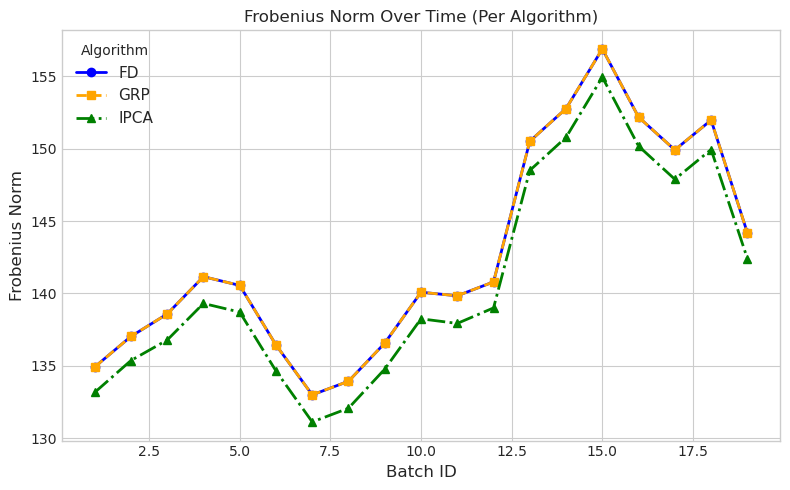

In [41]:
#Frobenius Norm
plt.figure(figsize=(8, 5))
for method, group in df.groupby("method"):
    plt.plot(group["batch_id"], group["fro_norm"], 
             label=method, linewidth=2,
             color=styles[method]["color"],
             marker=styles[method]["marker"],
             linestyle=styles[method]["linestyle"])

plt.title("Frobenius Norm Over Time (Per Algorithm)", fontdict=font)
plt.xlabel("Batch ID", fontdict=font)
plt.ylabel("Frobenius Norm", fontdict=font)
plt.legend(title="Algorithm", fontsize=11)
plt.tight_layout()
plt.show()

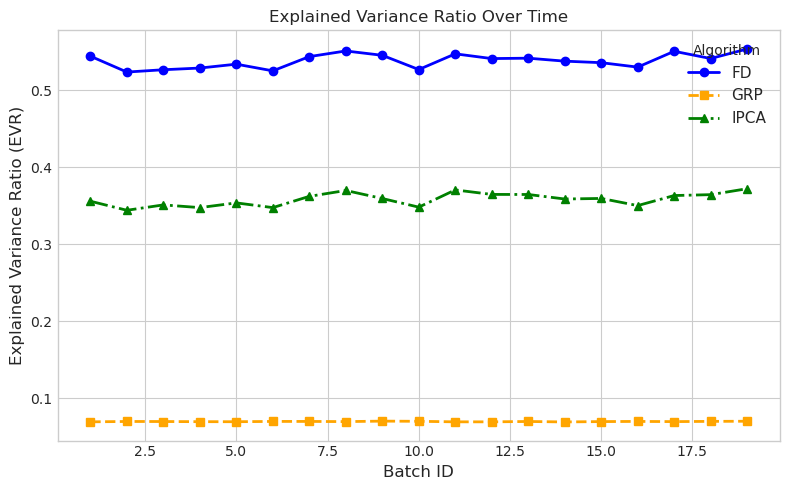

In [42]:
# Explained Variance Ratio 
plt.figure(figsize=(8, 5))
for method, group in df.groupby("method"):
    plt.plot(group["batch_id"], group["explained_variance_ratio"],
             label=method, linewidth=2,
             color=styles[method]["color"],
             marker=styles[method]["marker"],
             linestyle=styles[method]["linestyle"])

plt.title("Explained Variance Ratio Over Time", fontdict=font)
plt.xlabel("Batch ID", fontdict=font)
plt.ylabel("Explained Variance Ratio (EVR)", fontdict=font)
plt.legend(title="Algorithm", fontsize=11)
plt.tight_layout()
plt.show()

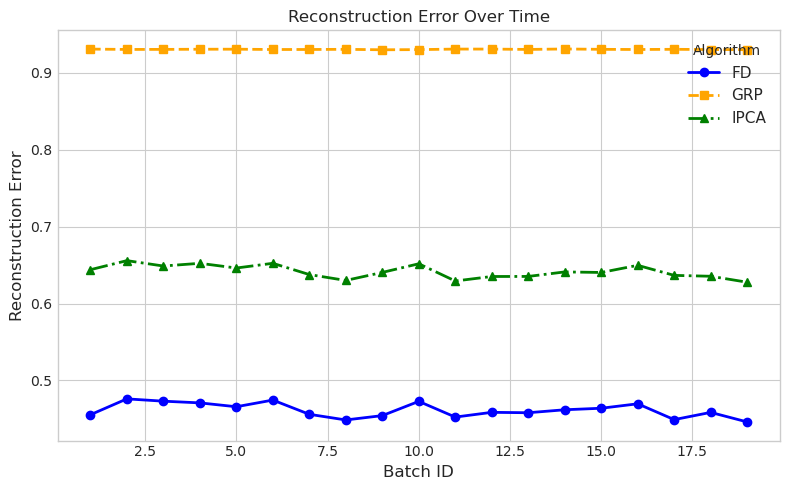

In [43]:
#Reconstruction Error
plt.figure(figsize=(8, 5))
for method, group in df.groupby("method"):
    plt.plot(group["batch_id"], group["reconstruction_error"],
             label=method, linewidth=2,
             color=styles[method]["color"],
             marker=styles[method]["marker"],
             linestyle=styles[method]["linestyle"])

plt.title("Reconstruction Error Over Time", fontdict=font)
plt.xlabel("Batch ID", fontdict=font)
plt.ylabel("Reconstruction Error", fontdict=font)
plt.legend(title="Algorithm", fontsize=11)
plt.tight_layout()
plt.show()

In [44]:
# Step 7 — Frequent Pattern Mining on original vs. sketched/reconstructed data
# Mine frequent itemsets per batch on:
#   1) ORIGINAL X
#   2) RECONSTRUCTIONS from GRP/IPCA/FD (X @ V @ V^T), then binarize per row (adaptive top-k)
# Compare speed and accuracy (top-N Jaccard, support MAE).

from pathlib import Path
import time
import re
import numpy as np
import pandas as pd
from scipy import sparse
import joblib

MIN_SUPPORT       = 0.02          # minimum support per batch
MAX_ITEMSET_LEN   = 3             # up to 3-itemsets
TOP_N_COMPARE     = 50            # compare top-N itemsets
ALGO              = "fpgrowth"    # "fpgrowth" or "apriori" (alias "fp_growth" also accepted)

from mlxtend.frequent_patterns import fpgrowth, apriori

In [45]:
d = X.shape[1]
stock_labels = item_index_to_stockcode.reset_index(drop=True)  # (d,)


In [46]:
grp_info = joblib.load(Path("artifacts/sketch_grp/grp_projection_matrix.joblib"))
R = grp_info["R"].astype(np.float32, copy=False)     # (d × k)
Q, _ = np.linalg.qr(R)                               # (d × k_orth)

ipca_files = sorted(Path("artifacts/sketch_ipca").glob("ipca_batch_*.joblib"),
                    key=lambda p: int(re.findall(r"(\d+)", p.stem)[-1]))
fd_files   = sorted(Path("artifacts/sketch_fd").glob("fd_batch_*.joblib"),
                    key=lambda p: int(re.findall(r"(\d+)", p.stem)[-1]))

In [47]:
def csr_to_boolean_df(X_csr: sparse.csr_matrix, cols_keep: np.ndarray) -> pd.DataFrame:
    X_sub = X_csr[:, cols_keep]
    df_bool = pd.DataFrame.sparse.from_spmatrix(
        X_sub.astype(bool),
        index=None,
        columns=stock_labels.iloc[cols_keep].to_list()
    )
    return df_bool.astype(bool)

def mine_itemsets(df_bool: pd.DataFrame, min_support: float, max_len: int, algo: str) -> pd.DataFrame:
    algo = algo.lower()
    if algo in ("fpgrowth", "fp_growth"):
        frq = fpgrowth(df_bool, min_support=min_support, use_colnames=True, max_len=max_len)
    else:
        frq = apriori(df_bool, min_support=min_support, use_colnames=True, max_len=max_len)
    frq = frq.sort_values(["support", "itemsets"], ascending=[False, True], ignore_index=True)
    return frq

def topN_signature(frq: pd.DataFrame, N: int) -> list[tuple]:
    sig = []
    for s in frq.head(N)["itemsets"]:
        items = tuple(sorted(list(s)))
        sig.append(items)
    return sig

def mae_on_common(frq_a: pd.DataFrame, frq_b: pd.DataFrame, N: int) -> float:
    a_top = frq_a.head(N).set_index(frq_a.head(N)["itemsets"].apply(lambda s: tuple(sorted(list(s)))))["support"]
    b_top = frq_b.head(N).set_index(frq_b.head(N)["itemsets"].apply(lambda s: tuple(sorted(list(s)))))["support"]
    common = a_top.index.intersection(b_top.index)
    if len(common) == 0:
        return np.nan
    return float(np.mean(np.abs(a_top.loc[common].values - b_top.loc[common].values)))

def project_reconstruct_boolean(Xb: sparse.csr_matrix, V: np.ndarray, cols_present: np.ndarray) -> pd.DataFrame:
    # Scores and reconstruction on present columns only
    S = (Xb @ V)                         # (n_b × r)
    V_sel = V[cols_present, :]           # (|cols_present| × r)
    X_hat_sel = S @ V_sel.T              # (n_b × |cols_present|)

    row_lengths = np.diff(Xb.indptr)
    k_avg = int(max(1, round(float(np.mean(row_lengths)))))
    n_b, m = X_hat_sel.shape

    keep_mat = np.zeros_like(X_hat_sel, dtype=bool)
    if m > 0:
        k_eff = min(k_avg, m)
        pos_mask = (X_hat_sel > 0)
        for i in range(n_b):
            row = X_hat_sel[i, :]
            if pos_mask[i].any():
                pos_idx = np.where(pos_mask[i])[0]
                k_row = min(k_eff, pos_idx.size)
                if k_row > 0:
                    top_idx = pos_idx[np.argpartition(row[pos_idx], -k_row)[-k_row:]]
                    keep_mat[i, top_idx] = True
            else:
                top_idx = np.argpartition(row, -k_eff)[-k_eff:]
                keep_mat[i, top_idx] = True

    df_bool = pd.DataFrame(keep_mat, columns=stock_labels.iloc[cols_present].to_list()).astype(bool)
    return df_bool


In [48]:
results_summary = []
out_dir = Path("artifacts/step7_fpm")
out_dir.mkdir(parents=True, exist_ok=True)

for b_idx, txn_ids in enumerate(stream_batches_txn_ids, start=1):
    print(f"\n=== Batch {b_idx:02d} ===")
    Xb = X[txn_ids, :]
    if not sparse.isspmatrix_csr(Xb):
        Xb = sparse.csr_matrix(Xb)

    cols_present = np.unique(Xb.indices)

    #Original
    t0 = time.perf_counter()
    df_orig = csr_to_boolean_df(Xb, cols_present)
    frq_orig = mine_itemsets(df_orig, MIN_SUPPORT, MAX_ITEMSET_LEN, ALGO)
    t_orig = time.perf_counter() - t0
    print(f"[Original] items={len(cols_present)}, baskets={Xb.shape[0]}, FIs={len(frq_orig)} time={t_orig:.3f}s")

    #GRP
    t0 = time.perf_counter()
    df_grp = project_reconstruct_boolean(Xb, Q, cols_present)
    frq_grp = mine_itemsets(df_grp, MIN_SUPPORT, MAX_ITEMSET_LEN, ALGO)
    t_grp = time.perf_counter() - t0
    sig_o, sig_g = set(topN_signature(frq_orig, TOP_N_COMPARE)), set(topN_signature(frq_grp, TOP_N_COMPARE))
    jacc_grp = (len(sig_o & sig_g) / max(1, len(sig_o | sig_g)))
    mae_grp  = mae_on_common(frq_orig, frq_grp, TOP_N_COMPARE)
    print(f"[GRP]      FIs={len(frq_grp)} time={t_grp:.3f}s Jaccard={jacc_grp:.3f} MAE={mae_grp:.4f}")

    #IPCA
    ipca_payload = joblib.load(ipca_files[b_idx - 1])
    V_ipca = ipca_payload["components"].astype(np.float32, copy=False)   # (d × r)
    t0 = time.perf_counter()
    df_ipca = project_reconstruct_boolean(Xb, V_ipca, cols_present)
    frq_ipca = mine_itemsets(df_ipca, MIN_SUPPORT, MAX_ITEMSET_LEN, ALGO)
    t_ipca = time.perf_counter() - t0
    sig_i = set(topN_signature(frq_ipca, TOP_N_COMPARE))
    jacc_ipca = (len(sig_o & sig_i) / max(1, len(sig_o | sig_i)))
    mae_ipca  = mae_on_common(frq_orig, frq_ipca, TOP_N_COMPARE)
    print(f"[IPCA]     FIs={len(frq_ipca)} time={t_ipca:.3f}s Jaccard={jacc_ipca:.3f} MAE={mae_ipca:.4f}")

    #FD
    fd_payload = joblib.load(fd_files[b_idx - 1])
    B_fd = fd_payload["B"].astype(np.float32, copy=False)                # (ℓ × d)
    _, _, Vt_fd = np.linalg.svd(B_fd, full_matrices=False)
    V_fd = Vt_fd.T.astype(np.float32, copy=False)
    t0 = time.perf_counter()
    df_fd = project_reconstruct_boolean(Xb, V_fd, cols_present)
    frq_fd = mine_itemsets(df_fd, MIN_SUPPORT, MAX_ITEMSET_LEN, ALGO)
    t_fd = time.perf_counter() - t0
    sig_f = set(topN_signature(frq_fd, TOP_N_COMPARE))
    jacc_fd = (len(sig_o & sig_f) / max(1, len(sig_o | sig_f)))
    mae_fd  = mae_on_common(frq_orig, frq_fd, TOP_N_COMPARE)
    print(f"[FD]       FIs={len(frq_fd)} time={t_fd:.3f}s Jaccard={jacc_fd:.3f} MAE={mae_fd:.4f}")

    out_dir.joinpath(f"orig_batch_{b_idx:02d}.csv").write_text(frq_orig.to_csv(index=False))
    out_dir.joinpath(f"grp_batch_{b_idx:02d}.csv").write_text(frq_grp.to_csv(index=False))
    out_dir.joinpath(f"ipca_batch_{b_idx:02d}.csv").write_text(frq_ipca.to_csv(index=False))
    out_dir.joinpath(f"fd_batch_{b_idx:02d}.csv").write_text(frq_fd.to_csv(index=False))

    results_summary.append({
        "batch_id": b_idx,
        "orig_FIs": len(frq_orig),
        "grp_FIs": len(frq_grp),
        "ipca_FIs": len(frq_ipca),
        "fd_FIs": len(frq_fd),
        "time_orig_s": t_orig,
        "time_grp_s": t_grp,
        "time_ipca_s": t_ipca,
        "time_fd_s": t_fd,
        "jaccard_grp": jacc_grp,
        "jaccard_ipca": jacc_ipca,
        "jaccard_fd": jacc_fd,
        "mae_grp": mae_grp,
        "mae_ipca": mae_ipca,
        "mae_fd": mae_fd,
    })


=== Batch 01 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2167, baskets=976, FIs=330 time=2.026s
[GRP]      FIs=183 time=0.289s Jaccard=0.562 MAE=0.0217
[IPCA]     FIs=3430 time=9.237s Jaccard=0.754 MAE=0.0780
[FD]       FIs=1386 time=3.261s Jaccard=0.613 MAE=0.0422

=== Batch 02 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2222, baskets=976, FIs=297 time=2.481s
[GRP]      FIs=149 time=0.189s Jaccard=0.493 MAE=0.0179
[IPCA]     FIs=2880 time=8.224s Jaccard=0.667 MAE=0.0772
[FD]       FIs=1122 time=2.977s Jaccard=0.639 MAE=0.0394

=== Batch 03 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2121, baskets=976, FIs=338 time=2.837s
[GRP]      FIs=206 time=0.130s Jaccard=0.493 MAE=0.0202
[IPCA]     FIs=3206 time=8.478s Jaccard=0.754 MAE=0.0786
[FD]       FIs=1200 time=2.718s Jaccard=0.754 MAE=0.0361

=== Batch 04 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2121, baskets=976, FIs=375 time=2.873s
[GRP]      FIs=198 time=0.148s Jaccard=0.538 MAE=0.0213


[IPCA]     FIs=2893 time=9.416s Jaccard=0.754 MAE=0.0667
[FD]       FIs=984 time=2.108s Jaccard=0.724 MAE=0.0346

=== Batch 05 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2083, baskets=976, FIs=395 time=3.207s
[GRP]      FIs=198 time=0.186s Jaccard=0.562 MAE=0.0207
[IPCA]     FIs=2978 time=8.626s Jaccard=0.639 MAE=0.0768
[FD]       FIs=1339 time=3.047s Jaccard=0.695 MAE=0.0360

=== Batch 06 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2146, baskets=976, FIs=360 time=2.660s
[GRP]      FIs=185 time=0.144s Jaccard=0.538 MAE=0.0195
[IPCA]     FIs=2318 time=7.387s Jaccard=0.724 MAE=0.0712
[FD]       FIs=899 time=2.598s Jaccard=0.754 MAE=0.0337

=== Batch 07 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2009, baskets=976, FIs=402 time=3.491s
[GRP]      FIs=173 time=0.168s Jaccard=0.515 MAE=0.0217
[IPCA]     FIs=2409 time=7.514s Jaccard=0.667 MAE=0.0722
[FD]       FIs=885 time=2.549s Jaccard=0.639 MAE=0.0316

=== Batch 08 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2084, baskets=976, FIs=448 time=2.781s
[GRP]      FIs=170 time=0.129s Jaccard=0.667 MAE=0.0235
[IPCA]     FIs=2618 time=7.674s Jaccard=0.639 MAE=0.0717
[FD]       FIs=1112 time=2.590s Jaccard=0.754 MAE=0.0313

=== Batch 09 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2153, baskets=976, FIs=411 time=3.695s
[GRP]      FIs=158 time=0.145s Jaccard=0.515 MAE=0.0226
[IPCA]     FIs=2844 time=7.966s Jaccard=0.639 MAE=0.0761
[FD]       FIs=1272 time=3.269s Jaccard=0.724 MAE=0.0355

=== Batch 10 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2251, baskets=976, FIs=521 time=4.734s
[GRP]      FIs=161 time=0.122s Jaccard=0.587 MAE=0.0255
[IPCA]     FIs=3264 time=8.834s Jaccard=0.695 MAE=0.0760
[FD]       FIs=1618 time=4.705s Jaccard=0.754 MAE=0.0375

=== Batch 11 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2166, baskets=976, FIs=531 time=5.183s
[GRP]      FIs=158 time=0.154s Jaccard=0.562 MAE=0.0235
[IPCA]     FIs=3744 time=10.289s Jaccard=0.639 MAE=0.0819
[FD]       FIs=1579 time=3.813s Jaccard=0.639 MAE=0.0362

=== Batch 12 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2253, baskets=976, FIs=664 time=5.614s
[GRP]      FIs=161 time=0.183s Jaccard=0.515 MAE=0.0257
[IPCA]     FIs=4040 time=11.184s Jaccard=0.613 MAE=0.0721
[FD]       FIs=1903 time=5.095s Jaccard=0.639 MAE=0.0373

=== Batch 13 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2257, baskets=976, FIs=512 time=3.938s
[GRP]      FIs=243 time=0.322s Jaccard=0.538 MAE=0.0203
[IPCA]     FIs=5460 time=15.960s Jaccard=0.613 MAE=0.0777
[FD]       FIs=2415 time=6.248s Jaccard=0.639 MAE=0.0415

=== Batch 14 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2372, baskets=976, FIs=477 time=4.101s
[GRP]      FIs=250 time=0.250s Jaccard=0.538 MAE=0.0201
[IPCA]     FIs=5929 time=16.654s Jaccard=0.613 MAE=0.0806
[FD]       FIs=2106 time=3.776s Jaccard=0.667 MAE=0.0438

=== Batch 15 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2429, baskets=976, FIs=464 time=2.875s
[GRP]      FIs=248 time=0.197s Jaccard=0.408 MAE=0.0224
[IPCA]     FIs=6365 time=12.165s Jaccard=0.639 MAE=0.0889
[FD]       FIs=2177 time=3.756s Jaccard=0.613 MAE=0.0462

=== Batch 16 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2326, baskets=976, FIs=404 time=2.336s
[GRP]      FIs=232 time=0.128s Jaccard=0.493 MAE=0.0205
[IPCA]     FIs=4703 time=8.899s Jaccard=0.724 MAE=0.0892
[FD]       FIs=1645 time=2.743s Jaccard=0.724 MAE=0.0502

=== Batch 17 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2332, baskets=976, FIs=442 time=2.451s
[GRP]      FIs=222 time=0.134s Jaccard=0.408 MAE=0.0234
[IPCA]     FIs=5670 time=11.110s Jaccard=0.639 MAE=0.0871
[FD]       FIs=2471 time=4.440s Jaccard=0.667 MAE=0.0470

=== Batch 18 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2326, baskets=976, FIs=431 time=2.897s
[GRP]      FIs=242 time=0.145s Jaccard=0.515 MAE=0.0218
[IPCA]     FIs=5027 time=9.692s Jaccard=0.667 MAE=0.0946
[FD]       FIs=1896 time=3.291s Jaccard=0.724 MAE=0.0501

=== Batch 19 ===


/tmp/ipykernel_1436/4107343399.py:3: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_bool = pd.DataFrame.sparse.from_spmatrix(


[Original] items=2251, baskets=968, FIs=352 time=2.091s
[GRP]      FIs=174 time=0.133s Jaccard=0.515 MAE=0.0183
[IPCA]     FIs=4226 time=8.023s Jaccard=0.639 MAE=0.0784
[FD]       FIs=1655 time=2.814s Jaccard=0.695 MAE=0.0455


In [49]:
df_summary = pd.DataFrame(results_summary)
print("\n=== Step 7 Summary (per-batch) ===")
print(df_summary.to_string(index=False))

df_summary.to_csv(out_dir / "summary.csv", index=False)
print(f"\n Saved per-batch itemsets to: {out_dir} (summary.csv)")


=== Step 7 Summary (per-batch) ===
 batch_id  orig_FIs  grp_FIs  ipca_FIs  fd_FIs  time_orig_s  time_grp_s  time_ipca_s  time_fd_s  jaccard_grp  jaccard_ipca  jaccard_fd  mae_grp  mae_ipca   mae_fd
        1       330      183      3430    1386     2.025798    0.288588     9.237319   3.261274     0.562500      0.754386    0.612903 0.021744  0.078036 0.042170
        2       297      149      2880    1122     2.481413    0.189033     8.223870   2.977182     0.492537      0.666667    0.639344 0.017884  0.077228 0.039381
        3       338      206      3206    1200     2.836697    0.129864     8.478223   2.718042     0.492537      0.754386    0.754386 0.020181  0.078631 0.036123
        4       375      198      2893     984     2.873496    0.147709     9.415769   2.108333     0.538462      0.754386    0.724138 0.021311  0.066741 0.034568
        5       395      198      2978    1339     3.207063    0.185978     8.626230   3.047207     0.562500      0.639344    0.694915 0.020691  0.07

In [50]:
# Step 8 — Anomaly Injection + Matrix Monitoring for abrupt change detection
# What this does:
# 1) Build a synthetic anomalous batch (Batch 20) with unusual co-occurrence patterns.
# 2) Run sketching on the new batch only: GRP (with existing R), IPCA (per-batch), FD (per-batch).
# 3) Compute monitoring metrics (Frobenius, EVR, Reconstruction Error) for Batch 20.
# 4) Append metrics to the historical series and detect anomalies via simple z-scores.
# 5) Plot time series with the anomalous batch highlighted.

In [51]:
np.random.seed(1234)               # reproducible anomaly
ANOMALY_TXN_COUNT = 300            # number of anomalous transactions in Batch 20
ANOMALY_BASKET_MIN = 12            # larger-than-normal baskets
ANOMALY_BASKET_MAX = 20
RARE_ITEM_CUTOFF = 0.01            # define "rare" items by global support < 1%


In [52]:
n_total, d = X.shape

item_counts = np.diff(X.tocsc().indptr)           # occurrences per item
global_support = item_counts / float(n_total)     # support in [0,1]
rare_items = np.where(global_support < RARE_ITEM_CUTOFF)[0]

if rare_items.size < 100:
    rare_items = np.where(global_support < 0.02)[0]
if rare_items.size == 0:
    rare_items = np.arange(d)

cluster_size = min(200, rare_items.size)          
cluster_items = np.random.choice(rare_items, size=cluster_size, replace=False)

rows = []
cols = []
for r in range(ANOMALY_TXN_COUNT):
    k = np.random.randint(ANOMALY_BASKET_MIN, ANOMALY_BASKET_MAX + 1)
    chosen = np.random.choice(cluster_items, size=min(k, cluster_size), replace=False)
    rows.extend([r] * len(chosen))
    cols.extend(chosen.tolist())

data = np.ones(len(rows), dtype=np.float32)
X_anom = sparse.csr_matrix((data, (rows, cols)), shape=(ANOMALY_TXN_COUNT, d))

X_aug = sparse.vstack([X, X_anom], format="csr")

start_idx = n_total
end_idx = n_total + ANOMALY_TXN_COUNT
batch20_txn_ids = np.arange(start_idx, end_idx, dtype=int)

stream_batches_txn_ids.append(batch20_txn_ids)

print(f"[Anomaly] Built Batch 20 with {ANOMALY_TXN_COUNT} anomalous transactions, "
      f"dense baskets over {cluster_size} rare items.")

[Anomaly] Built Batch 20 with 300 anomalous transactions, dense baskets over 200 rare items.


In [53]:

grp_dir = Path("artifacts/sketch_grp")
grp_dir.mkdir(parents=True, exist_ok=True)
grp_info = joblib.load(grp_dir / "grp_projection_matrix.joblib")
R = grp_info["R"].astype(np.float32, copy=False)   # (d × k)

Xb20 = X_aug[batch20_txn_ids, :]                   # CSR
Y20 = (Xb20 @ R).astype(np.float32, copy=False)

grp_b20_path = grp_dir / "grp_batch_20.joblib"
joblib.dump({"batch_id": 20,
             "txn_ids": batch20_txn_ids,
             "Y_batch": Y20,
             "k": int(R.shape[1])}, grp_b20_path)

grp_manifest_path = grp_dir / "grp_manifest.joblib"
if grp_manifest_path.exists():
    manifest = joblib.load(grp_manifest_path)
else:
    manifest = {"batches": []}
if isinstance(manifest, dict):
    manifest_list = manifest.get("batches", [])
    manifest_list.append({"batch_id": 20, "file": str(grp_b20_path)})
    manifest["batches"] = manifest_list
else:
    manifest.append({"batch_id": 20, "file": str(grp_b20_path)})
joblib.dump(manifest, grp_manifest_path)
print("[GRP] Saved Batch 20 sketch and updated manifest.")

def gram_schmidt_orth(x, V_list):
    if not V_list:
        nrm = np.linalg.norm(x)
        return x / nrm if nrm > 0 else x
    for v in V_list:
        x -= (v @ x) * v
    nrm = np.linalg.norm(x)
    return x / nrm if nrm > 0 else x

n_b20, d = Xb20.shape
mu20 = np.asarray(Xb20.sum(axis=0)).ravel() / float(n_b20)
ones20 = np.ones(n_b20, dtype=np.float64)

def cov_times_b20(w):
    w = w.astype(np.float64, copy=False)
    Xw = Xb20.dot(w)
    z = Xw - float(mu20 @ w) * ones20
    Ct_w = (Xb20.T.dot(z)) / float(n_b20)
    return np.asarray(Ct_w).ravel()

rng = np.random.default_rng(123)
k_ipca = 50 if d >= 50 else max(2, d)
n_iter = 7
tol = 1e-6
V_ipca = []
S_ipca = []
for comp in range(k_ipca):
    w = rng.normal(size=d)
    w = gram_schmidt_orth(w, V_ipca)
    if np.linalg.norm(w) == 0:
        break
    last_val = 0.0
    for _ in range(n_iter):
        u = cov_times_b20(w)
        u = gram_schmidt_orth(u, V_ipca)
        nrm = np.linalg.norm(u)
        if nrm == 0:
            break
        w = u / nrm
        lam = float(w @ cov_times_b20(w))
        if abs(lam - last_val) <= tol * max(1.0, abs(lam)):
            break
        last_val = lam
    eigval = float(w @ cov_times_b20(w))
    if eigval <= 0 or not np.isfinite(eigval):
        break
    V_ipca.append(w.astype(np.float32, copy=False))
    S_ipca.append(eigval)
V_ipca = np.stack(V_ipca, axis=1) if len(V_ipca) else np.zeros((d,0), dtype=np.float32)
S_ipca = np.array(S_ipca, dtype=np.float32)

ipca_dir = Path("artifacts/sketch_ipca")
ipca_dir.mkdir(parents=True, exist_ok=True)
ipca_b20_path = ipca_dir / "ipca_batch_20.joblib"
joblib.dump({
    "batch_id": 20,
    "txn_ids": batch20_txn_ids,
    "mean_batch": mu20.astype(np.float32, copy=False),
    "components": V_ipca,
    "explained_variances": S_ipca,
    "n_samples_batch": int(n_b20),
    "n_features": int(d),
}, ipca_b20_path)
print("[IPCA] Saved Batch 20 IPCA sketch.")

fd_dir = Path("artifacts/sketch_fd")
fd_dir.mkdir(parents=True, exist_ok=True)

ell = 128 if d >= 128 else min(d, 128)
B = np.zeros((2*ell, d), dtype=np.float32)
next_row = 0
indptr, indices, data = Xb20.indptr, Xb20.indices, Xb20.data

def fd_shrink(B_buf, ell):
    U, s, Vt = np.linalg.svd(B_buf, full_matrices=False)
    delta = s[ell - 1] ** 2
    s_shrunk_sq = np.maximum(s**2 - delta, 0.0)
    s_top = np.sqrt(s_shrunk_sq[:ell])
    Vt_top = Vt[:ell, :]
    return (s_top[:, None] * Vt_top).astype(np.float32, copy=False)

for r in range(n_b20):
    st, ed = indptr[r], indptr[r+1]
    cols = indices[st:ed]
    vals = data[st:ed]
    B[next_row, cols] = vals.astype(np.float32, copy=False)
    next_row += 1
    if next_row == 2*ell:
        B = fd_shrink(B, ell)
        B = np.vstack([B, np.zeros((ell, d), dtype=np.float32)])
        next_row = ell

if next_row > ell:
    B_final = fd_shrink(B[:next_row, :], ell)
else:
    B_final = B[:ell, :].copy()

fd_b20_path = fd_dir / "fd_batch_20.joblib"
joblib.dump({
    "batch_id": 20,
    "txn_ids": batch20_txn_ids,
    "B": B_final,
    "ell": ell,
    "n_rows_batch": int(n_b20),
    "n_features": int(d),
}, fd_b20_path)
print("[FD] Saved Batch 20 FD sketch.")


[GRP] Saved Batch 20 sketch and updated manifest.
[IPCA] Saved Batch 20 IPCA sketch.
[FD] Saved Batch 20 FD sketch.


In [54]:
metrics_path = Path("artifacts/step5_metrics.csv")
if not metrics_path.exists():
    raise FileNotFoundError("Missing artifacts/step5_metrics.csv from Step 5.")

df_hist = pd.read_csv(metrics_path)
df_hist = df_hist.sort_values(["batch_id", "method"]).reset_index(drop=True)

def frobenius_sq_sparse(Xb_csr):
    return float((Xb_csr.multiply(Xb_csr)).sum())

E_unc_sq_20 = frobenius_sq_sparse(Xb20)
E_unc_20 = np.sqrt(E_unc_sq_20)

RtR = R.T @ R
RtR_inv = np.linalg.inv(RtR)
S = Y20.T @ Y20
E_grp_pres_sq_20 = float(np.trace(RtR_inv @ S))
EVR_grp_20 = (E_grp_pres_sq_20 / E_unc_sq_20) if E_unc_sq_20 > 0 else 0.0
RE_grp_20 = 1.0 - EVR_grp_20

mu_b20 = mu20.astype(np.float64, copy=False)
V = V_ipca.astype(np.float64, copy=False)
r = V.shape[1]
E_centered_total_sq_20 = max(E_unc_sq_20 - n_b20 * float(mu_b20 @ mu_b20), 0.0)
if r > 0:
    XbV = Xb20 @ V
    muV = mu_b20 @ V
    T = XbV - np.outer(np.ones(n_b20, dtype=np.float64), muV)
    E_ipca_pres_sq_20 = float((T * T).sum())
    EVR_ipca_20 = (E_ipca_pres_sq_20 / E_centered_total_sq_20) if E_centered_total_sq_20 > 0 else 0.0
    RE_ipca_20 = 1.0 - EVR_ipca_20
else:
    EVR_ipca_20 = 0.0
    RE_ipca_20 = 1.0

Ub, sb, Vt_b = np.linalg.svd(B_final.astype(np.float64, copy=False), full_matrices=False)
Vb = Vt_b.T
XbVb = Xb20 @ Vb
E_fd_pres_sq_20 = float((XbVb * XbVb).sum())
EVR_fd_20 = (E_fd_pres_sq_20 / E_unc_sq_20) if E_unc_sq_20 > 0 else 0.0
RE_fd_20 = 1.0 - EVR_fd_20

rec20 = pd.DataFrame([
    {"batch_id": 20, "method": "GRP",  "n_samples": n_b20, "n_features": d,
     "fro_norm": E_unc_20, "explained_variance_ratio": EVR_grp_20,  "reconstruction_error": RE_grp_20},
    {"batch_id": 20, "method": "IPCA", "n_samples": n_b20, "n_features": d,
     "fro_norm": np.sqrt(E_centered_total_sq_20) if E_centered_total_sq_20 > 0 else 0.0,
     "explained_variance_ratio": EVR_ipca_20, "reconstruction_error": RE_ipca_20},
    {"batch_id": 20, "method": "FD",   "n_samples": n_b20, "n_features": d,
     "fro_norm": E_unc_20, "explained_variance_ratio": EVR_fd_20,   "reconstruction_error": RE_fd_20},
])

df_all = pd.concat([df_hist, rec20], ignore_index=True).sort_values(["batch_id", "method"])
df_all.to_csv(metrics_path, index=False)
print("[Metrics] Appended Batch 20 metrics to artifacts/step5_metrics.csv")

[Metrics] Appended Batch 20 metrics to artifacts/step5_metrics.csv


In [55]:
def anomaly_scores(series_vals, val_at_20):
    vals = np.array(series_vals, dtype=float)
    mu = np.mean(vals)
    sd = np.std(vals, ddof=1) if len(vals) > 1 else 0.0
    z = (val_at_20 - mu) / sd if sd > 0 else np.nan
    return mu, sd, z

report_rows = []
for method in ["GRP", "IPCA", "FD"]:
    df_m = df_all[df_all["method"] == method].sort_values("batch_id")
    evr_vals = df_m[df_m["batch_id"] < 20]["explained_variance_ratio"].values
    re_vals  = df_m[df_m["batch_id"] < 20]["reconstruction_error"].values
    evr20 = float(df_m[df_m["batch_id"] == 20]["explained_variance_ratio"])
    re20  = float(df_m[df_m["batch_id"] == 20]["reconstruction_error"])

    mu_evr, sd_evr, z_evr = anomaly_scores(evr_vals, evr20)   # lower EVR => anomaly (drop)
    mu_re,  sd_re,  z_re  = anomaly_scores(re_vals,  re20)    # higher RE  => anomaly (rise)

    report_rows.append({
        "method": method,
        "EVR_mean_prev": mu_evr, "EVR_std_prev": sd_evr, "EVR_at_20": evr20, "z_EVR": (evr20 - mu_evr)/(sd_evr if sd_evr>0 else np.nan),
        "RE_mean_prev": mu_re,   "RE_std_prev": sd_re,   "RE_at_20": re20,   "z_RE":  (re20  - mu_re) /(sd_re  if sd_re>0 else np.nan),
        "EVR_drop_flag(>|-3|)": (z_evr <= -3.0) if not np.isnan(z_evr) else False,
        "RE_rise_flag(>+3)":    (z_re  >= +3.0) if not np.isnan(z_re)  else False,
    })

df_anom = pd.DataFrame(report_rows)
print("\n=== Step 8 — Anomaly report (batch 20 vs history) ===")
print(df_anom.to_string(index=False))



=== Step 8 — Anomaly report (batch 20 vs history) ===
method  EVR_mean_prev  EVR_std_prev  EVR_at_20     z_EVR  RE_mean_prev  RE_std_prev  RE_at_20       z_RE  EVR_drop_flag(>|-3|)  RE_rise_flag(>+3)
   GRP       0.069830      0.000285   0.070214  1.347195      0.930170     0.000285  0.929786  -1.347195                 False              False
  IPCA       0.358483      0.008544   0.551612 22.603099      0.641517     0.008544  0.448388 -22.603099                 False              False
    FD       0.538575      0.009452   0.917872 40.129096      0.461425     0.009452  0.082128 -40.129096                 False              False


/tmp/ipykernel_1436/3986586263.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  evr20 = float(df_m[df_m["batch_id"] == 20]["explained_variance_ratio"])
/tmp/ipykernel_1436/3986586263.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  re20  = float(df_m[df_m["batch_id"] == 20]["reconstruction_error"])


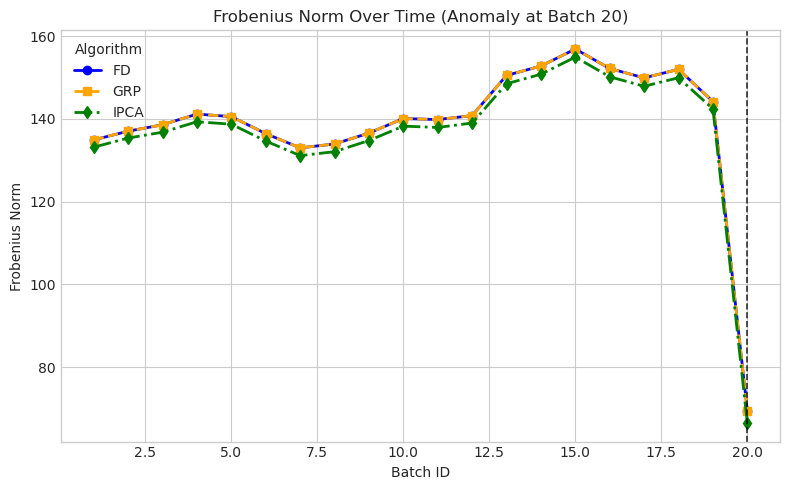

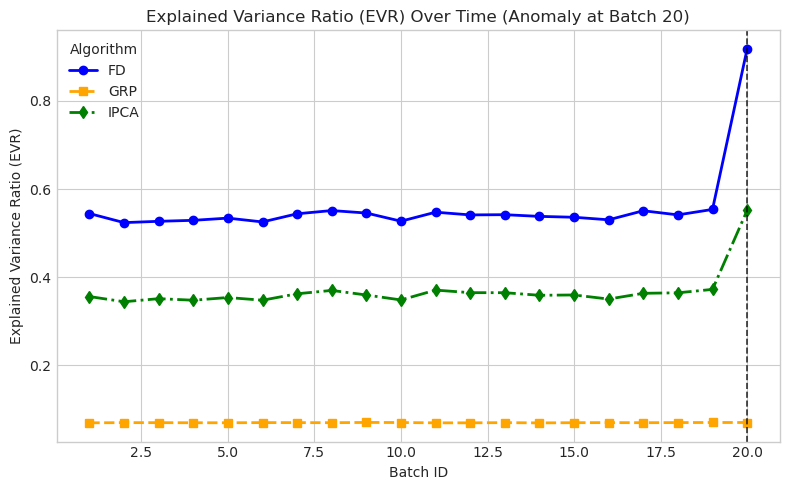

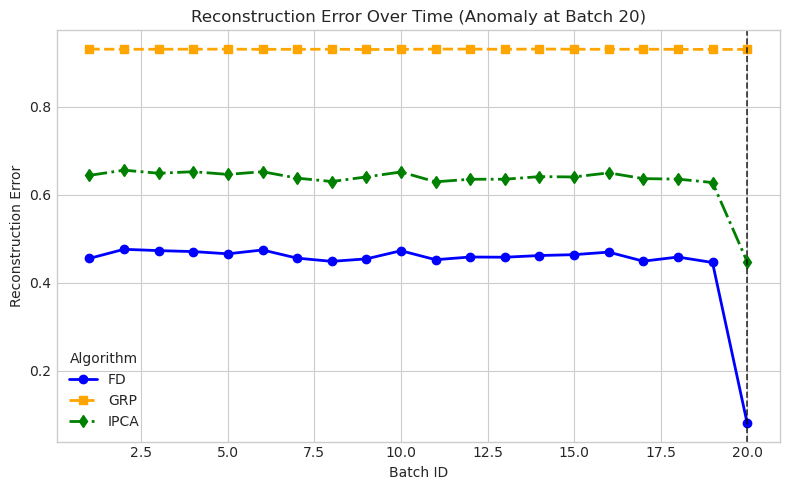

In [56]:
for col, ylabel in [
    ("fro_norm", "Frobenius Norm"),
    ("explained_variance_ratio", "Explained Variance Ratio (EVR)"),
    ("reconstruction_error", "Reconstruction Error"),
]:
    plt.figure(figsize=(8, 5))

    styles = {
        "FD":  {"color": "blue",   "linestyle": "-",  "marker": "o",  "label": "FD"},
        "GRP": {"color": "orange", "linestyle": "--", "marker": "s",  "label": "GRP"},
        "IPCA":{"color": "green",  "linestyle": "-.", "marker": "d",  "label": "IPCA"},
    }

    for method in ["FD", "GRP", "IPCA"]:
        g = df_all[df_all["method"] == method].sort_values("batch_id")
        plt.plot(
            g["batch_id"].values,
            g[col].values,
            linewidth=2,
            linestyle=styles[method]["linestyle"],
            marker=styles[method]["marker"],
            color=styles[method]["color"],
            label=styles[method]["label"]
        )

    plt.axvline(20, linestyle="--", color="black", linewidth=1.2, alpha=0.8)

    plt.title(f"{ylabel} Over Time (Anomaly at Batch 20)")
    plt.xlabel("Batch ID")
    plt.ylabel(ylabel)
    plt.legend(title="Algorithm")
    plt.tight_layout()
    plt.show()

